In [1]:
import numpy as np

from pathlib import Path
import random

import pandas as pd
pd.set_option('display.max_columns', None)

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors

from sklearn.model_selection import train_test_split

import sys
sys.path.insert(0, '/code/src')

from data_utils import load_nwb, get_stim_window, get_spike_counts
from plot_utils import create_raster, create_psth
from classifier import fit_classifier, run_classifier

In [2]:
example_sessions = [1139846596, 1152811536, 1069461581 ]
this_session = str(example_sessions[0])
this_filename = f'ecephys_session_{this_session}.nwb'
nwb_path = Path('visual_behavior_neuropixels', 'visual-behavior-neuropixels-0.4.0', 'behavior_ecephys_sessions', this_session, this_filename)
session, units_table, stimuli = load_nwb(nwb_path)

stimuli_type = 'Natural_Images_Lum_Matched_set_ophys_H_2019_presentations'
stimuli = stimuli[stimuli_type].to_dataframe()
unq_stim, stim_id = np.unique(stimuli.image_name, return_inverse = True)

In [3]:
# Choose a neuron to analyze
unit = 6
spike_times = units_table.spike_times.values[unit]
stim_times = stimuli.start_time.values

# Create a raster
triggered_spike_times, triggered_stim_index = get_stim_window(spike_times, stim_times)

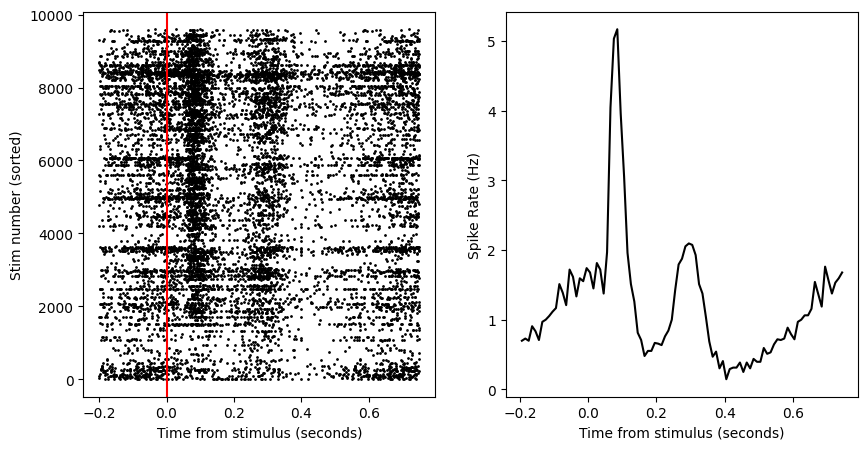

In [4]:
fig, ax = plt.subplots(ncols = 2,figsize =(10, 5))

create_raster(triggered_spike_times, triggered_stim_index, ax[0])
create_psth(triggered_spike_times, triggered_stim_index, ax[1])

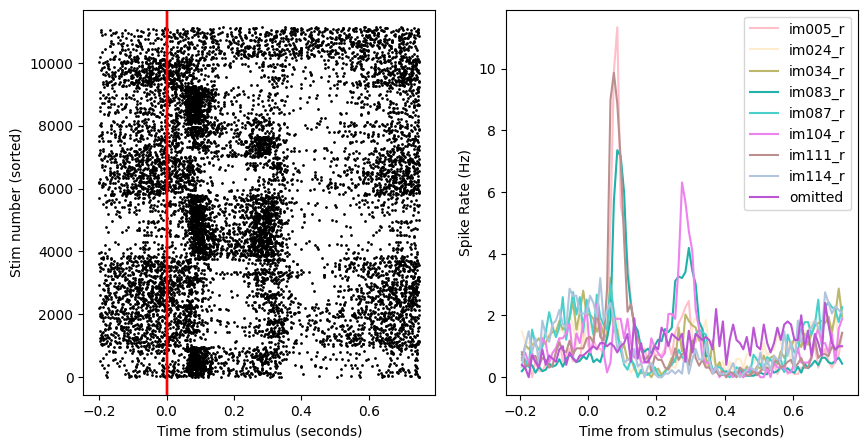

In [5]:
fig,ax = plt.subplots(ncols = 2, figsize = (10, 5))

colors = list(mcolors.CSS4_COLORS)
random.shuffle(colors)

# A counter, useful for stacking plots
counter = 0

# Loop through trial types

for ii in range(len(unq_stim)):
    # Plot the raster just for this stimulus type

    # spike times for this trial type
    this_triggered_spike_times = triggered_spike_times[stim_id[triggered_stim_index.astype(int)]==ii]

    # trial index subselected by this trial type.
    this_trl_idx = np.arange(np.sum(stim_id[triggered_stim_index.astype(int)]==ii)) 

    # Plot
    create_raster(this_triggered_spike_times, this_trl_idx + counter, ax[0])
    
    # stack the plots
    counter += np.max(this_trl_idx)
    
    # Plot the raster just for this stimulus type
    color = colors[ii]
    create_psth(this_triggered_spike_times, this_trl_idx, ax[1], label=unq_stim[ii], color=color)
ax[1].legend() # Plot a legend using the established labels.

In [6]:
spike_count, trial_id = get_spike_counts(spike_times, stim_times, stimuli)

x_train, x_test, y_train, y_test = train_test_split(spike_count, trial_id)
svc = fit_classifier(x_train, y_train)
y_pred, score = run_classifier(svc, x_test, y_test)